In [1]:
import numpy as np
import ctypes
import pyautogui

from PIL import Image, ImageDraw

In [2]:
user32 = ctypes.windll.user32
screenSize = user32.GetSystemMetrics(0), user32.GetSystemMetrics(1)
centerPoint = tuple(i/2 for i in screenSize)
monitor_width = screenSize[0]
monitor_height = screenSize[1]

In [3]:
full_screen_image = pyautogui.screenshot(region=(0, 0, monitor_width, monitor_height))

In [4]:
survey_scan_results_box = [1610, 1076, 2050, 1332] #x,y Top Left ,x,y Bottom Right

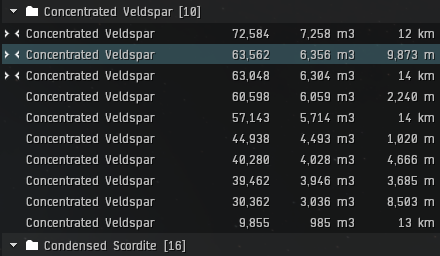

In [5]:
full_screen_image.crop(survey_scan_results_box)

In [6]:
import decimal

def drange(x, y, jump):
    while x < y:
        yield float(x)
        x += decimal.Decimal(jump)
        
def cell_dims(x1, y1, x2, y2):
    return x1, y1, x2 - x1, y2 - y1

def cell_dims_from_list(list_onbj):
    return cell_dims(list_onbj[0], list_onbj[1], list_onbj[2], list_onbj[3])

In [7]:
space = (survey_scan_results_box[3] - survey_scan_results_box[1]) / 12
row_points= list(drange(survey_scan_results_box[1], survey_scan_results_box[3], f'{space}'))
final_row_points = list(np.rint(np.asarray(row_points)).astype(int))
final_row_points

[1076, 1097, 1119, 1140, 1161, 1183, 1204, 1225, 1247, 1268, 1289, 1311, 1332]

In [8]:
col_delta = survey_scan_results_box[2] - survey_scan_results_box[0]
cols_points =  [col_delta * .05, col_delta * .45, col_delta * .15, col_delta * .18]

temp_list = []

for i in range(len(cols_points)):
    this_int = survey_scan_results_box[0]
    for j in range(i + 1):
        this_int += cols_points[j]
    temp_list.append(this_int)

final_col_points = np.array(temp_list)

final_col_points = list(np.rint(final_col_points).astype(int))
final_col_points = [survey_scan_results_box[0]] + final_col_points + [survey_scan_results_box[2]]
final_col_points

[1610, 1632, 1830, 1896, 1975, 2050]

In [9]:
x_range = final_col_points
y_range = final_row_points

cells = {}

for i, x in enumerate(x_range):
    for j, y in enumerate(y_range):
        try:
            cells[i, j] = tuple([x, y, x + x_range[i+1], y + y_range[j+1]])
        except:
            pass

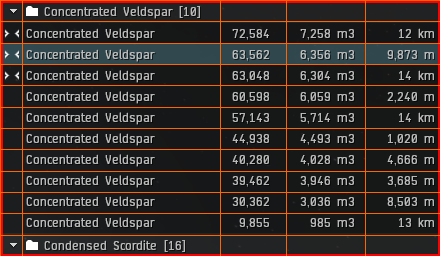

In [10]:
full_screen_image_copy = full_screen_image.copy()
img1 = ImageDraw.Draw(full_screen_image_copy)  

# box
img1.line([survey_scan_results_box[0], survey_scan_results_box[1], survey_scan_results_box[0], survey_scan_results_box[3]], fill ="red", width = 5)
img1.line([survey_scan_results_box[0], survey_scan_results_box[3], survey_scan_results_box[2], survey_scan_results_box[3]], fill ="red", width = 5)
img1.line([survey_scan_results_box[2], survey_scan_results_box[3],survey_scan_results_box[2], survey_scan_results_box[1]], fill ="red", width = 5)
img1.line([survey_scan_results_box[2], survey_scan_results_box[1],survey_scan_results_box[0], survey_scan_results_box[1]], fill ="red", width = 5)
# rows
for i in final_row_points:
    img1.line([survey_scan_results_box[0], i, survey_scan_results_box[2], i], fill="#ff6600", width=1)
# cols
for i in final_col_points:
    img1.line([i, survey_scan_results_box[1], i, survey_scan_results_box[3]], fill="#ff6600", width=1)


full_screen_image_copy.crop(survey_scan_results_box)

In [11]:
from pytesseract import pytesseract
import pandas as pd
from tqdm import tqdm

# Models
https://github.com/tesseract-ocr/tessdata_best/blob/main/eng.traineddata  
C:\Program Files\Tesseract-OCR\tessdata

In [31]:
frames = []
columns = ['Locked', 'Ore', 'Quantity', 'Volume', 'Distance', 'click_target']
for i in tqdm(range(12)):
    frame = {}
    for j in range(0, 5):
        cell = cell_dims_from_list(list(cells[j, i]))
        cell_image = full_screen_image.crop(cell)

        transcript = pytesseract.image_to_string(cell_image, lang='eng')
        
        frame[columns[j]] = transcript.replace('\n','').replace('+','').replace('>','').replace('k m', ' km')
    frame['click_target'] = (cells[1, i][0] + 10, cells[1, i][1] + 10) # offset by 10x10 pixels
    frames.append(frame)
df = pd.DataFrame(frames, columns=columns)
df.loc[df['Locked'] != '', 'Locked'] = '><'
df

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:07<00:00,  1.60it/s]


,Locked,Ore,Quantity,Volume,Distance,click_target
0,,Mu Concentrated Veldspar [18],,,,"(1642, 1086)"
1,><,Concentrated Veldspar,"72,584","7,258 m3",12 km,"(1642, 1107)"
2,><,Concentrated Veldspar,63562,"6,356 m3",9.873 m,"(1642, 1129)"
3,><,Concentrated Veldspar,"63,048","6,304 m3",14 km,"(1642, 1150)"
4,,Concentrated Veldspar,"60,598","6,858 m3",2248 m,"(1642, 1171)"
5,,Concentrated Veldspar,"57,143","5,714 m3",14 km,"(1642, 1193)"
6,,Concentrated Veldspar,"44,938","4,493 m3","1,028 m","(1642, 1214)"
7,,Concentrated Veldspar,"40,280",40828 m3,4666 m,"(1642, 1235)"
8,,Concentrated Veldspar,"39,462","3,946 m3","3,685 m","(1642, 1257)"
9,,Concentrated Veldspar,"30,362","3,836 m3",8503 m,"(1642, 1278)"


In [35]:
pyautogui.moveTo(df['click_target'][5])
pyautogui.keyDown('ctrl')
pyautogui.click()
pyautogui.keyUp('ctrl')

(1642, 1171)